In [10]:
# Import basic packages lik numpy, pandas, math plot and seaborn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
from sklearn.svm import SVC

In [11]:
# import dataset
df = pd.read_csv('https://raw.githubusercontent.com/lijjumathew/MSDS-Machine-Learning-1-Project/master/dataset/Telco-Customer-Churn.csv')

In [12]:
#Ideally SeniorCitizen column should be a factor, so let's convert 1,0 values to Yes,No and later we can label encode all factor columns
df.SeniorCitizen=df.SeniorCitizen.apply(lambda x: 'Yes' if x==1 else 'No')

# Getting rid of unwanted columns like Customer Id.
if 'customerID' in df:
    del df['customerID']
    
# converting TotalCharges object dataset into numeric
# errors = 'coerce’ means, if invalid parsing occur then set NaN
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors = 'coerce')

# Replacing blank values with nulls.
df=df.replace(r'^\s*$', np.nan, regex=True)

# Total charges has some blank values/missing values and needs to be imputed. Filling the missing values
df["TotalCharges"].fillna(df["TotalCharges"].mean(), inplace=True)

# Consolidate MultipleLines attribute
df['MultipleLines'] = df['MultipleLines'].replace('No phone service','No')

# Change all values of 'No internet service' to 'No'
df = df.replace('No internet service','No')

# Replace all yes/no values with 1/0
df = df.replace(to_replace=['Yes','No'], value=[1,0])

# Create dummy variables in the entire dataset
df = pd.get_dummies(df)

In [13]:
# Separate the churn results from the dataset
y = df['Churn'].values
x = df.drop(columns = ['Churn'])

# Set features
features = x.columns.values

# Normalize values
scale = MinMaxScaler(feature_range = (0,1))
scale.fit(x)
x = pd.DataFrame(scale.transform(x))
x.columns = features

In [14]:
# Set up train/test split with 80/20 ratio
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size = 0.2, random_state = 99)

# Create the model and fit
model = LogisticRegression()
fit = model.fit(x_train,y_train)
predict = model.predict(x_test)
print("Our accuracy score of the model using logistic regression is: ",metrics.accuracy_score(y_test,predict))
print(classification_report(y_test,predict))

Our accuracy score of the model using logistic regression is:  0.7998580553584103
              precision    recall  f1-score   support

           0       0.84      0.90      0.87      1023
           1       0.67      0.54      0.60       386

    accuracy                           0.80      1409
   macro avg       0.75      0.72      0.73      1409
weighted avg       0.79      0.80      0.79      1409



In [15]:
# Calculate and display weights from logistic regression
weights = pd.Series(model.coef_[0], index=x.columns.values)
print(weights.sort_values(ascending = False))

TotalCharges                               0.987158
InternetService_Fiber optic                0.822797
Contract_Month-to-month                    0.698867
PaperlessBilling                           0.371334
PaymentMethod_Electronic check             0.292634
MultipleLines                              0.240501
SeniorCitizen                              0.233807
StreamingTV                                0.181166
StreamingMovies                            0.180732
gender_Female                              0.016114
InternetService_DSL                        0.014568
Contract_One year                          0.007922
MonthlyCharges                             0.000814
gender_Male                               -0.015306
PaymentMethod_Mailed check                -0.020221
DeviceProtection                          -0.023484
Partner                                   -0.056451
PaymentMethod_Credit card (automatic)     -0.118700
Dependents                                -0.131897
OnlineBackup

In [18]:
from sklearn.preprocessing import StandardScaler

# we want to normalize the features based upon the mean and standard deviation of each column. 
# However, we do not want to accidentally use the testing data to find out the mean and std (this would be snooping)
# to Make things easier, let's start by just using whatever was last stored in the variables:
##    X_train , y_train , X_test, y_test (they were set in a for loop above)

# scale attributes by the training set
scl_obj = StandardScaler()
scl_obj.fit(x_train) # find scalings for each column that make this zero mean and unit std
# the line of code above only looks at training data to get mean and std and we can use it 
# to transform new feature data

x_train_scaled = scl_obj.transform(x_train) # apply to training
x_test_scaled = scl_obj.transform(x_test) # apply those means and std to the test set (without snooping at the test set values)

# train the model just as before
lr_clf = LogisticRegression(penalty='l2', C=0.05, solver='liblinear') # get object, the 'C' value is less (can you guess why??)
lr_clf.fit(x_train_scaled,y_train)  # train object

y_hat = lr_clf.predict(x_test_scaled) # get test set precitions

acc = metrics.accuracy_score(y_test,y_hat)
conf = metrics.confusion_matrix(y_test,y_hat)
print('accuracy:', acc )
print(conf )

# sort these attributes and spit them out
zip_vars = zip(lr_clf.coef_.T,df.columns) # combine attributes
zip_vars = sorted(zip_vars)
for coef, name in zip_vars:
    print(name, 'has weight of', coef[0]) # now print them out

accuracy: 0.7970191625266146
[[917 106]
 [180 206]]
tenure has weight of -0.7827311937436199
gender_Male has weight of -0.32070095610618543
Contract_One year has weight of -0.28773904658151106
OnlineSecurity has weight of -0.1958241896445182
TechSupport has weight of -0.14652320642901462
PhoneService has weight of -0.13398740382899915
Contract_Two year has weight of -0.07215701589537192
OnlineBackup has weight of -0.07200490850248643
Dependents has weight of -0.05994537197821957
PaymentMethod_Bank transfer (automatic) has weight of -0.05805321342249012
Contract_Month-to-month has weight of -0.04554570180008888
InternetService_0 has weight of -0.039620713048057914
Partner has weight of -0.030930329684588604
DeviceProtection has weight of -0.020756366654210413
PaymentMethod_Electronic check has weight of -0.017051146972409954
gender_Female has weight of -0.007851641497605106
Churn has weight of 0.007851641497605422
StreamingMovies has weight of 0.06950857432974661
StreamingTV has weight 

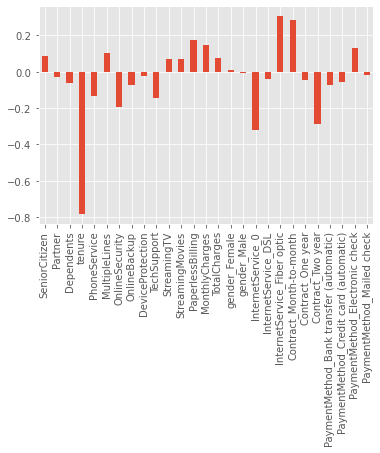

In [19]:
# now let's make a pandas Series with the names and values, and plot them
from matplotlib import pyplot as plt
%matplotlib inline
plt.style.use('ggplot')


weights = pd.Series(lr_clf.coef_[0],index=x.columns.values)
weights.plot(kind='bar')
plt.show()

AxesSubplot(0.125,0.125;0.775x0.755)


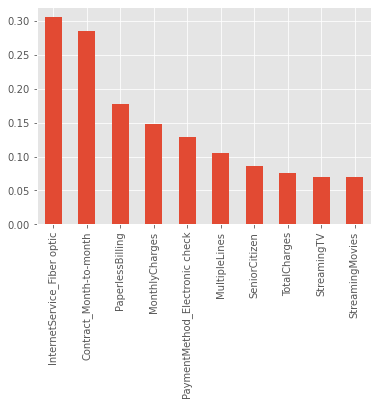

In [21]:
# To get the weights of all the variables
weights = pd.Series(lr_clf.coef_[0],
                 index=x.columns.values)
print (weights.sort_values(ascending = False)[:10].plot(kind='bar'))

AxesSubplot(0.125,0.125;0.775x0.755)


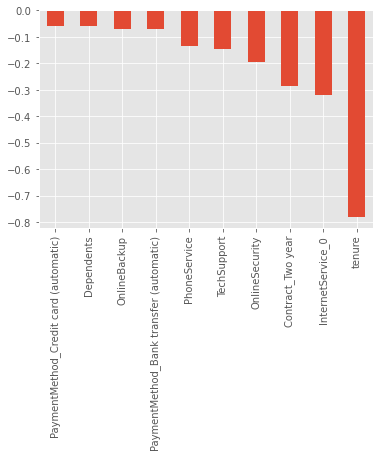

In [22]:
print(weights.sort_values(ascending = False)[-10:].plot(kind='bar'))


# Observations

We can see that some variables have a negative relation to our predicted variable (Churn), while some have positive relation. Negative relation means that likeliness of churn decreases with that variable. Let us summarize some of the interesting features below:

As we saw in our EDA, having a monthly contract reduces chances of churn. monthly contract along with tenure have the most negative relation with Churn as predicted by logistic regressions Having DSL internet service also reduces the proability of Churn Lastly, total charges, monthly contracts, fibre optic internet services and seniority can lead to higher churn rates. This is interesting because although fibre optic services are faster, customers are likely to churn because of it. I think we need to explore more to better understad why this is happening. Any hypothesis on the above would be really helpful!

In [23]:
# Fit and predict using SVM
# Support Vectors are the data points that are closest to the edges of the margin of the separating line.
# The separating line and margins are called the hyperplane
svm = SVC(kernel='rbf',cache_size=1000)
svm.fit(x_train,y_train)
predict = svm.predict(x_test)
print("Our accuracy score of the model using SVM is: ",metrics.accuracy_score(y_test,predict))
print("This is about the same as our logistic regression model")

Our accuracy score of the model using SVM is:  0.7955997161107168
This is about the same as our logistic regression model


In [24]:
# Confusion matrix
print(confusion_matrix(y_test,predict))

[[930  93]
 [195 191]]


# Observations
With SVM we get accuracy of up to 79%